
# Pendulum Equation Discovery — Ridge & ElasticNet + Classification

**Contents**
- Generate or load pendulum dataset (columns: `theta`, `theta_dot`, `theta_ddot`)
- Feature engineering: `sin(theta)`, `theta_dot_squared`
- Combined Ridge and ElasticNet regression to model `theta_ddot`
- Classification models (KNN with LOOCV, Logistic Regression, SVM, LDA) to predict stability (pass/fail)
- Rosenbrock function validation (synthetic test)
- Save outputs (MSE, coefficients, confusion matrices) to `outputs/`


In [2]:
! pip install numpy
! pip install pandas
! pip install matplotlib
! pip install scikit-learn
! pip install joblib
! pip install nbformat

In [6]:
# run in notebook cell
import sys, os
print("sys.executable:", sys.executable)
print("sys.version:", sys.version)
# show pip that will be used by python -m pip
import subprocess
print("pip version:", subprocess.run([sys.executable, "-m", "pip", "--version"], capture_output=True, text=True).stdout)

sys.executable: c:\Users\naksh\AppData\Local\Programs\Python\Python311\python.exe
sys.version: 3.11.3 (tags/v3.11.3:f3909b8, Apr  4 2023, 23:49:59) [MSC v.1934 64 bit (AMD64)]
pip version: pip 25.2 from c:\Users\naksh\AppData\Local\Programs\Python\Python311\Lib\site-packages\pip (python 3.11)




In [10]:

# Imports and setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneOut, cross_val_score
from sklearn.linear_model import Ridge, ElasticNet, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

import os
from pathlib import Path

# === Base project directory ===
BASE = Path.cwd()  # or manually set Path("C:/Users/naksh/Downloads/pendulum_project")

# === Define subdirectories ===
DATA_DIR = BASE / "data"
OUT_DIR = BASE / "outputs"

# === Create folders if not existing ===
DATA_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("✅ Directory structure ready:")
print("Data Directory:", DATA_DIR.resolve())
print("Output Directory:", OUT_DIR.resolve())



✅ Directory structure ready:
Data Directory: C:\Users\naksh\OneDrive\Documents\pendulum_project\pendulum_project\notebooks\data
Output Directory: C:\Users\naksh\OneDrive\Documents\pendulum_project\pendulum_project\notebooks\outputs


In [11]:
df = pd.read_csv('pendulum_data.csv')

df.to_csv(DATA_DIR / 'pendulum_data.csv', index=False)
df.head()

,theta,theta_dot,theta_double_dot
0,0.040431,-0.069829,0.029322
1,-0.151797,-0.662335,0.138360
2,-0.584669,0.797156,0.446742
3,-0.151016,-0.772319,0.016372
4,0.256469,0.188715,-0.298235


In [12]:

# Load data (generated above) and feature engineering
df = pd.read_csv(DATA_DIR / 'pendulum_data.csv')

# Features: theta, sin(theta), theta_dot, theta_dot^2
df['sin_theta'] = np.sin(df['theta'])
df['theta_dot_sq'] = df['theta_dot'] ** 2

features = ['theta', 'sin_theta', 'theta_dot', 'theta_dot_sq']
target = 'theta_double_dot'

X = df[features].values
y = df[target].values

# Standardize features for regression/classification
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print('Data shapes:', X_train.shape, X_test.shape)


Data shapes: (800, 4) (200, 4)


In [13]:

# Combined Ridge and ElasticNet regression with hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Ridge regression
ridge = Ridge()
param_grid_ridge = {'alpha': [0.01, 0.1, 1, 10, 100]}
grid_ridge = GridSearchCV(ridge, param_grid_ridge, cv=5, scoring='neg_mean_squared_error')
grid_ridge.fit(X_train, y_train)
best_ridge = grid_ridge.best_estimator_
y_pred_ridge = best_ridge.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

# ElasticNet regression
en = ElasticNet(max_iter=5000)
param_grid_en = {'alpha': [0.001, 0.01, 0.1, 1], 'l1_ratio': [0.1, 0.5, 0.9]}
grid_en = GridSearchCV(en, param_grid_en, cv=5, scoring='neg_mean_squared_error')
grid_en.fit(X_train, y_train)
best_en = grid_en.best_estimator_
y_pred_en = best_en.predict(X_test)
mse_en = mean_squared_error(y_test, y_pred_en)
r2_en = r2_score(y_test, y_pred_en)

print("Ridge best alpha:", grid_ridge.best_params_, "MSE:", mse_ridge, "R2:", r2_ridge)
print("ElasticNet best params:", grid_en.best_params_, "MSE:", mse_en, "R2:", r2_en)

# Save coefficients and metrics
coef_df = pd.DataFrame({
    'feature': features,
    'ridge_coef': best_ridge.coef_,
    'en_coef': best_en.coef_
})
coef_df.to_csv(OUT_DIR / 'regression_coefficients.csv', index=False)

metrics = pd.DataFrame({
    'model': ['Ridge', 'ElasticNet'],
    'mse': [mse_ridge, mse_en],
    'r2': [r2_ridge, r2_en]
})
metrics.to_csv(OUT_DIR / 'regression_metrics.csv', index=False)

# Save models
joblib.dump(best_ridge, OUT_DIR / 'ridge_model.joblib')
joblib.dump(best_en, OUT_DIR / 'elasticnet_model.joblib')


Ridge best alpha: {'alpha': 10} MSE: 0.020591075119711314 R2: 0.87491548456551
ElasticNet best params: {'alpha': 0.01, 'l1_ratio': 0.1} MSE: 0.020510117679580313 R2: 0.8754072763787462


['c:\\Users\\naksh\\OneDrive\\Documents\\pendulum_project\\pendulum_project\\notebooks\\outputs\\elasticnet_model.joblib']

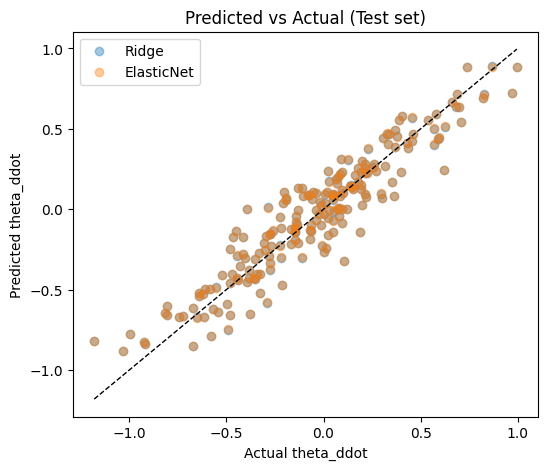

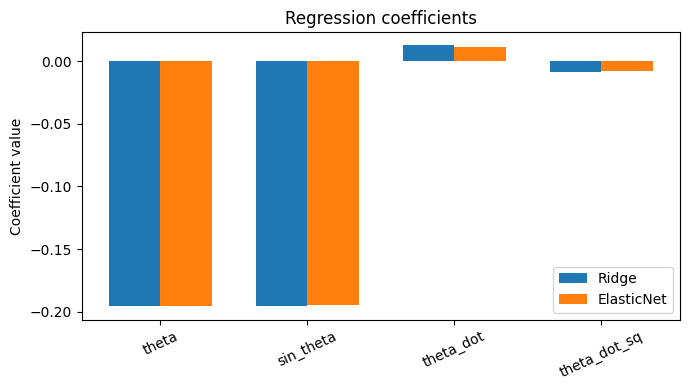

In [14]:

# Regression plots: Pred vs Actual, coefficients
plt.figure(figsize=(6,5))
plt.scatter(y_test, y_pred_ridge, alpha=0.4, label='Ridge')
plt.scatter(y_test, y_pred_en, alpha=0.4, label='ElasticNet')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
plt.xlabel('Actual theta_ddot')
plt.ylabel('Predicted theta_ddot')
plt.legend()
plt.title('Predicted vs Actual (Test set)')
plt.savefig(OUT_DIR / 'pred_vs_actual.png', dpi=150)
plt.show()

# coefficient bar chart
x = np.arange(len(features))
width = 0.35
plt.figure(figsize=(7,4))
plt.bar(x - width/2, best_ridge.coef_, width, label='Ridge')
plt.bar(x + width/2, best_en.coef_, width, label='ElasticNet')
plt.xticks(x, features, rotation=25)
plt.ylabel('Coefficient value')
plt.title('Regression coefficients')
plt.legend()
plt.tight_layout()
plt.savefig(OUT_DIR / 'coefficients.png', dpi=150)
plt.show()


In [2]:
import numpy as np

Running KNN LOOCV...
k=1, LOOCV accuracy=0.9912
k=3, LOOCV accuracy=0.9875
k=5, LOOCV accuracy=0.9875
k=7, LOOCV accuracy=0.9900
✅ Best k found: 1 (Accuracy=0.9912)

📊 KNN Classification Report:
              precision    recall  f1-score   support

  Stable (0)       1.00      0.99      1.00       198
Unstable (1)       0.67      1.00      0.80         2

    accuracy                           0.99       200
   macro avg       0.83      1.00      0.90       200
weighted avg       1.00      0.99      1.00       200



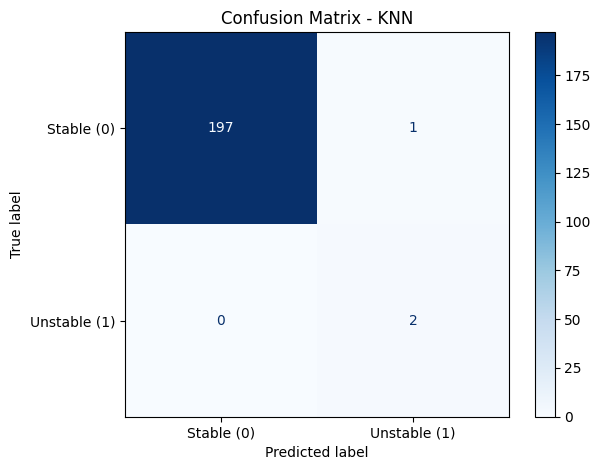


📊 LogisticRegression Classification Report:
              precision    recall  f1-score   support

  Stable (0)       0.99      1.00      0.99       198
Unstable (1)       0.00      0.00      0.00         2

    accuracy                           0.99       200
   macro avg       0.49      0.50      0.50       200
weighted avg       0.98      0.99      0.99       200



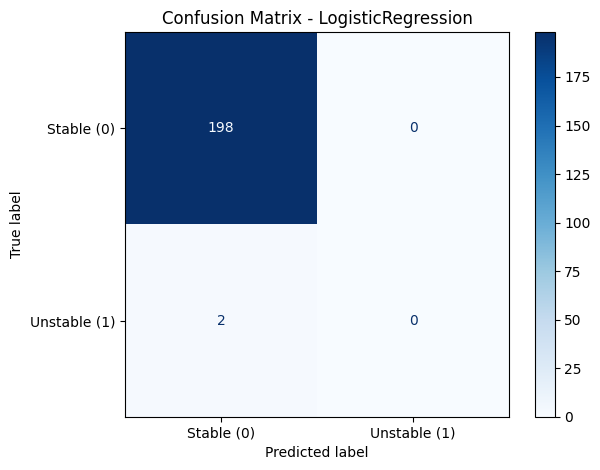


📊 SVM Classification Report:
              precision    recall  f1-score   support

  Stable (0)       0.99      1.00      0.99       198
Unstable (1)       0.00      0.00      0.00         2

    accuracy                           0.99       200
   macro avg       0.49      0.50      0.50       200
weighted avg       0.98      0.99      0.99       200



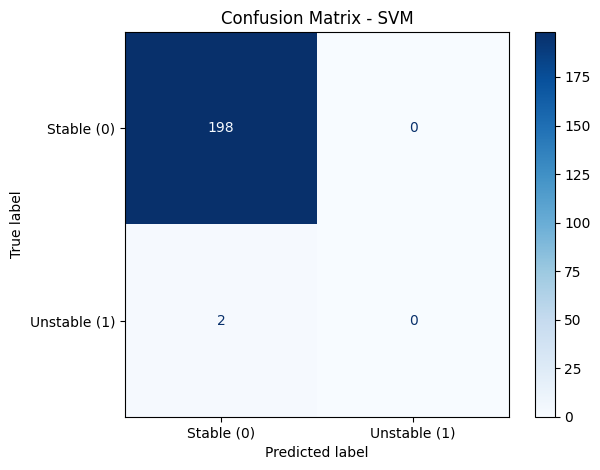


📊 LDA Classification Report:
              precision    recall  f1-score   support

  Stable (0)       1.00      1.00      1.00       198
Unstable (1)       1.00      1.00      1.00         2

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



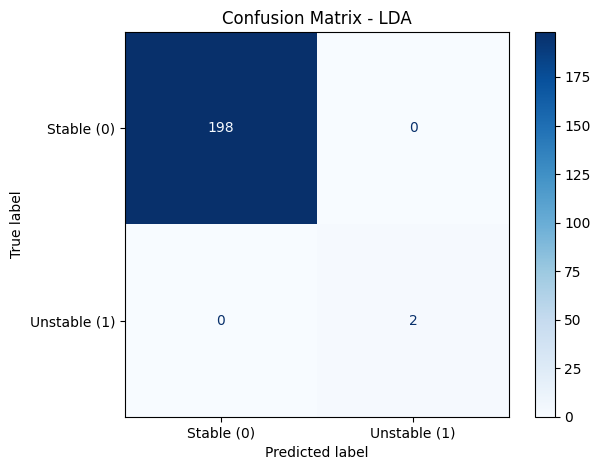


✅ All classification results saved in: C:\Users\naksh\OneDrive\Documents\pendulum_project\pendulum_project\notebooks\outputs\classification_outputs


In [ ]:
import os
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# =========================================================
# CLASSIFICATION PIPELINE
# =========================================================

# 1️⃣ Generate binary stability labels (0 = stable, 1 = unstable)
theta_threshold = 1.0  # adjust if needed
df['label'] = (np.abs(df['theta']) >= theta_threshold).astype(int)

# 2️⃣ Feature matrix and labels
X_cls = df[features].values
X_cls_scaled = scaler.transform(X_cls)  # use same scaler from regression
y_cls = df['label'].values

# 3️⃣ Split into train/test
Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_cls_scaled, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)

# =========================================================
# Create dedicated output folder for classification results
# =========================================================
OUT_CLS = OUT_DIR / "classification_outputs"
OUT_CLS.mkdir(parents=True, exist_ok=True)

# =========================================================
# 4️⃣ KNN with Leave-One-Out CV to find best k
# =========================================================
print("Running KNN LOOCV...")
loo = LeaveOneOut()
best_k = 3
best_score = -1
for k in [1, 3, 5, 7]:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, Xc_train, yc_train, cv=loo, scoring='accuracy')
    mean_score = scores.mean()
    print(f"k={k}, LOOCV accuracy={mean_score:.4f}")
    if mean_score > best_score:
        best_score = mean_score
        best_k = k

print(f"✅ Best k found: {best_k} (Accuracy={best_score:.4f})")

knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(Xc_train, yc_train)
yc_pred_knn = knn_final.predict(Xc_test)

# =========================================================
# 5️⃣ Train other classifiers
# =========================================================
logreg = LogisticRegression(max_iter=2000)
logreg.fit(Xc_train, yc_train)
yc_pred_log = logreg.predict(Xc_test)

svc = SVC(probability=True)
svc.fit(Xc_train, yc_train)
yc_pred_svc = svc.predict(Xc_test)

lda = LinearDiscriminantAnalysis()
lda.fit(Xc_train, yc_train)
yc_pred_lda = lda.predict(Xc_test)

# =========================================================
# 6️⃣ Evaluate all models and store outputs
# =========================================================
models = {
    "KNN": (knn_final, yc_pred_knn),
    "LogisticRegression": (logreg, yc_pred_log),
    "SVM": (svc, yc_pred_svc),
    "LDA": (lda, yc_pred_lda),
}

reports = {}

for name, (model, ypred) in models.items():
    print(f"\n {name} Classification Report:")
    report = classification_report(yc_test, ypred, target_names=["Stable (0)", "Unstable (1)"])
    print(report)
    
    # Save report as JSON
    reports[name] = classification_report(yc_test, ypred, output_dict=True)
    
    # Confusion Matrix
    cm = confusion_matrix(yc_test, ypred)
    disp = ConfusionMatrixDisplay(cm, display_labels=["Stable (0)", "Unstable (1)"])
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Confusion Matrix - {name}")
    plt.tight_layout()
    
    # Save each confusion matrix
    plt.savefig(OUT_CLS / f"cm_{name}.png", dpi=150)
    plt.show()  #  Show in notebook
    plt.close()

# =========================================================
# 7 Save all reports as one JSON file
# =========================================================
import json
with open(OUT_CLS / "classification_reports.json", "w") as f:
    json.dump(reports, f, indent=2)

print(f"\n All classification results saved in: {OUT_CLS.resolve()}")


In [16]:

# Rosenbrock function validation (synthetic)
def rosenbrock(x, y, a=1, b=100):
    return (a - x)**2 + b*(y - x**2)**2

# generate data in 2D and try to fit with ElasticNet/Ridge as a regression sanity check
xx = np.random.uniform(-2, 2, 1000)
yy = np.random.uniform(-1, 3, 1000)
zz = rosenbrock(xx, yy)
# features: x, y, x^2, xy
X_rb = np.vstack([xx, yy, xx**2, xx*yy]).T
scaler_rb = StandardScaler()
X_rb_s = scaler_rb.fit_transform(X_rb)
Xrb_train, Xrb_test, z_train, z_test = train_test_split(X_rb_s, zz, test_size=0.2, random_state=42)

# Fit ElasticNet and Ridge quickly
from sklearn.linear_model import ElasticNet, Ridge
en_rb = ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=5000).fit(Xrb_train, z_train)
rd_rb = Ridge(alpha=1.0).fit(Xrb_train, z_train)
zpred_en = en_rb.predict(Xrb_test)
zpred_rd = rd_rb.predict(Xrb_test)

mse_en_rb = mean_squared_error(z_test, zpred_en)
mse_rd_rb = mean_squared_error(z_test, zpred_rd)
print('Rosenbrock MSE - ElasticNet:', mse_en_rb, 'Ridge:', mse_rd_rb)

# save a surface scatter plot of true vs predicted
plt.figure(figsize=(6,4))
plt.scatter(z_test, zpred_en, alpha=0.5, label='ElasticNet')
plt.scatter(z_test, zpred_rd, alpha=0.5, label='Ridge')
plt.plot([z_test.min(), z_test.max()], [z_test.min(), z_test.max()], 'k--')
plt.xlabel('True Rosenbrock')
plt.ylabel('Predicted')
plt.legend()
plt.title('Rosenbrock: Pred vs True')
plt.savefig(OUT_DIR / 'rosenbrock_pred_vs_true.png', dpi=150)
plt.close()

# Save Rosenbrock metrics
rb_metrics = {'elasticnet_mse': float(mse_en_rb), 'ridge_mse': float(mse_rd_rb)}
import json
with open(OUT_DIR / 'rosenbrock_metrics.json', 'w') as f:
    json.dump(rb_metrics, f, indent=2)


Rosenbrock MSE - ElasticNet: 127626.5208906405 Ridge: 127557.24428039968



## Final notes

- Replace `data/pendulum_data.csv` with real experimental data if available (columns: `theta`, `theta_dot`, `theta_ddot`).  
- Adjust the classification threshold (`theta_threshold`) to match your domain definition of stability.  
- The notebook saves all important outputs to the `outputs/` folder.  
- For GitHub, open the notebook and run cells to reproduce all outputs.  


In [17]:
# show where the notebook is writing outputs and list files
print("OUT_DIR (raw):", OUT_DIR)
print("OUT_DIR (resolved):", OUT_DIR.resolve())
print("exists:", OUT_DIR.exists())
print("contents:", [p.name for p in OUT_DIR.glob('*')])

OUT_DIR (raw): c:\Users\naksh\OneDrive\Documents\pendulum_project\pendulum_project\notebooks\outputs
OUT_DIR (resolved): C:\Users\naksh\OneDrive\Documents\pendulum_project\pendulum_project\notebooks\outputs
exists: True
contents: ['classification_outputs', 'coefficients.png', 'elasticnet_model.joblib', 'pred_vs_actual.png', 'regression_coefficients.csv', 'regression_metrics.csv', 'ridge_model.joblib', 'rosenbrock_metrics.json', 'rosenbrock_pred_vs_true.png']
